In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:
data = pd.read_csv('../input/environmental-sensor-data-132k/iot_telemetry_data.csv', engine='python')

In [3]:
data

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000
...,...,...,...,...,...,...,...,...,...
405179,1.595203e+09,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405180,1.595203e+09,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000
405181,1.595203e+09,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000
405182,1.595203e+09,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001


In [4]:
# !pip install -q pandas-profiling[notebook]
# from pandas_profiling import ProfileReport
# profile = ProfileReport(data, title='Pandas Profiling Report')
# profile.to_notebook_iframe()

# Tasks 

- The stated task is "Use ML to Determine when a Person is near IoT Device"

- As we don't have labels of time stamps where people are near the IoT device we are limited to unsupervised clustering of the data

- We do however, have three different devices in different locations

- The proximity of a person could affect the recorded parameters in the following ways:

-- Would CO levels be impacted by the presence of an individual? Perhaps, if they are breathing air near the sensor the CO will stick to their Haemoglobin permanently (this is how Carbon Monoxide poisons you) effectively scrubbing some of it from the atmosphere like a filter and leading to detectable reduction in CO ppm

-- Humidity might increase if a person is exhaling into the room

-- Light levels might drop if a person is occluding the light sensor

-- LPG levels might drop if a person breathes it in and thereby filters it from the local atmosphere

-- The movement of an individual near to a sensor would create detectable motion, though some information about other sources of motion/vibration would be needed to attribute it to a nearby person

-- Again, smoke levels could be reduced by the filtering effect of a persons lungs or increased if a person lights up a cigarette infront of the smoke sensor

-- The ambient temperature might be increase by the presence of a person next to the temperature sensor for a period of time

# Approach

- Lets plot the time series again with a more meaningful time scale (time of day might indicate when people are more likely to be nearby)

- Lets find out if there are any daily patterns the data

- Attempt to perform clustering on windows of time series data to define plausible "humans are nearby" intervals (i.e corresponding to light/motion/atmospheric/temperature changes)

# Exploring the time series

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


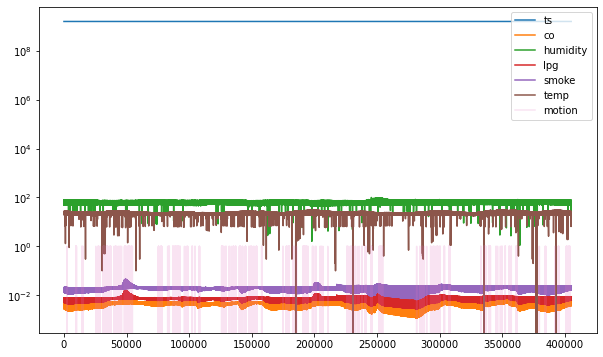

In [5]:
# plot the dataset with a log scale so everything can be viewed on the same axes effectively
ax = data.plot(logy = True, figsize = (10, 6));
data['motion'].astype(int).plot(ax=ax, alpha = 0.2);
ax.legend();
#data['light'].astype(int).plot(ax=ax, alpha = 0.2);

- From the plot above we can see a few things:
 1.  CO, LPG and smoke levels (air quality metrics) are correlated
 2.  Dramatic swings in temperature are recorded (are they real?) as well as more moderate temperature oscillations 
 3.  There are spikes in humidity
 4.  There are clusters of motion spikes interspersed with moitionless intervals

In [7]:
data['light_int'] = data['light'].astype('int32')

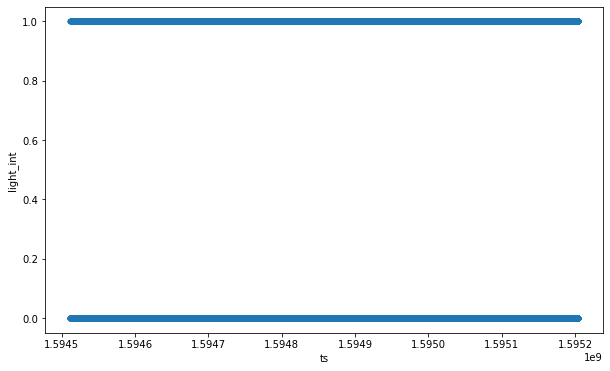

In [8]:
data.plot.scatter(x = 'ts', y = 'light_int', figsize = (10, 6));

In [9]:
data['light'].value_counts()

False    292657
True     112527
Name: light, dtype: int64

In [10]:
lightcount = 292657 + 112527
true_frac = 112527 / lightcount
print(true_frac)
false_frac = 292657 / lightcount
print(false_frac)

0.27771827120518083
0.7222817287948191


- So the light column reminds me that we are looking at overlapping data from three sensors in three distinct locations, some of which may be in darkness and some in light at least during the day, so a groupby on the 'devices' column will be necessary to properly interpret the data

# Any daily patterns in the data?

In [11]:
# convert unix time to time of day
from datetime import datetime, timedelta
start = datetime(1970, 1, 1)  # Unix epoch start time
data['datetime'] = data.ts.apply(lambda x: start + timedelta(seconds=x))
data['string_time'] = data.datetime.apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

In [12]:
data['string_time']

0         2020-07-12 00:01:34
1         2020-07-12 00:01:34
2         2020-07-12 00:01:38
3         2020-07-12 00:01:39
4         2020-07-12 00:01:41
                 ...         
405179    2020-07-20 00:03:33
405180    2020-07-20 00:03:33
405181    2020-07-20 00:03:36
405182    2020-07-20 00:03:36
405183    2020-07-20 00:03:37
Name: string_time, Length: 405184, dtype: object

In [13]:
data.columns

Index(['ts', 'device', 'co', 'humidity', 'light', 'lpg', 'motion', 'smoke',
       'temp', 'light_int', 'datetime', 'string_time'],
      dtype='object')

In [22]:
data_device_gb = data.groupby('device')

In [26]:
for i in data_device_gb:
    print(i)

('00:0f:00:70:91:0a',                   ts             device        co   humidity  light       lpg  \
1       1.594512e+09  00:0f:00:70:91:0a  0.002840  76.000000  False  0.005114   
7       1.594512e+09  00:0f:00:70:91:0a  0.002938  76.000000  False  0.005241   
15      1.594512e+09  00:0f:00:70:91:0a  0.002905  75.800003  False  0.005199   
20      1.594512e+09  00:0f:00:70:91:0a  0.002938  75.800003  False  0.005241   
23      1.594512e+09  00:0f:00:70:91:0a  0.002840  76.000000  False  0.005114   
...              ...                ...       ...        ...    ...       ...   
405169  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.300003  False  0.006247   
405172  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.400002  False  0.006247   
405175  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.400002  False  0.006247   
405179  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.300003  False  0.006247   
405182  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.300003  False  0.006247   

     

In [17]:
!pip install -q plotly

In [31]:
# plot our time series again with a more meaningful time axis and the ability to scroll and zoom

cols = ['co', 'humidity', 'lpg', 'motion', 'smoke',
       'temp']
unwanted_cols = set(['ts', 'device', 'light', 'datetime', 'string_time'])
import plotly.express as px 
fig = px.line()
for z in data_device_gb:
    for i, j in enumerate(cols):
        if j in unwanted_cols:
            continue
        fig.add_scatter(x=z[-1], y=z[i], mode='lines')
fig.update_layout(yaxis_type="log")
fig.show()

                  ts             device        co   humidity  light       lpg  \
1       1.594512e+09  00:0f:00:70:91:0a  0.002840  76.000000  False  0.005114   
7       1.594512e+09  00:0f:00:70:91:0a  0.002938  76.000000  False  0.005241   
15      1.594512e+09  00:0f:00:70:91:0a  0.002905  75.800003  False  0.005199   
20      1.594512e+09  00:0f:00:70:91:0a  0.002938  75.800003  False  0.005241   
23      1.594512e+09  00:0f:00:70:91:0a  0.002840  76.000000  False  0.005114   
...              ...                ...       ...        ...    ...       ...   
405169  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.300003  False  0.006247   
405172  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.400002  False  0.006247   
405175  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.400002  False  0.006247   
405179  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.300003  False  0.006247   
405182  1.595203e+09  00:0f:00:70:91:0a  0.003745  75.300003  False  0.006247   

        motion     smoke   

ValueError: 
    Invalid value of type 'builtins.str' received for the 'y' property of scatter
        Received value: '00:0f:00:70:91:0a'

    The 'y' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

# Any differences between the three sensor devices in different locations?

# Unsupervised learning to identify time series windows where humans are near